# Straight lines

In [17]:
# !wget https://img.freepik.com/free-photo/empty-highway-asphalt-road-beautiful-sky_51195-3950.jpg?size=626&ext=jpg
!wget -O image.png https://cdn1.byjus.com/wp-content/uploads/2020/10/Properties-of-Rectangle.png

--2021-01-03 09:17:50--  https://cdn1.byjus.com/wp-content/uploads/2020/10/Properties-of-Rectangle.png
Resolving cdn1.byjus.com (cdn1.byjus.com)... 99.86.35.32, 99.86.35.41, 99.86.35.90, ...
Connecting to cdn1.byjus.com (cdn1.byjus.com)|99.86.35.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13461 (13K) [image/png]
Saving to: ‘image.png’

image.png           100%[===================>]  13.15K  --.-KB/s    in 0s      

2021-01-03 09:17:51 (183 MB/s) - ‘image.png’ saved [13461/13461]



In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [19]:
SIZE = 100
WIDTH, HEIGHT = 500, 300

D = np.sqrt(WIDTH**2 + HEIGHT**2)
DELTA_THETA = 2 * np.pi / SIZE 
DELTA_P = 2 * D / SIZE

In [20]:
def draw_line(img, points):
  img = img.copy()
  for point in points:
    cv2.line(img, (int(point[0]), point[1]), (point[2], point[3]), (255,0,0), 3)
  return img

In [21]:
class HoughTransform:
  def __init__(self):
    pass

  def get_voting_res_from_table(self, table):
    indices = np.unravel_index(np.argsort(table.ravel()), (3,4))
    value = table[indices]
    return np.hstack((np.dstack(b)[0], c.reshape(-1,1)))
  def get_pos_max(self, table):
    return np.unravel_index(np.argmax(table.ravel()), table.shape)

  def clean_neighbor(self, table, pos, sp):
    y,x = pos
    x1 = np.clip(x-sp, 0, table.shape[1])
    x2 = np.clip(x+sp, 0, table.shape[1]) + 1
    y1 = np.clip(y-sp, 0, table.shape[0])
    y2 = np.clip(y+sp, 0, table.shape[0]) + 1

    table[y1:y2, x1:x2 ] = 0

  def c2d(self, i, kind):
    if kind == 'theta':
      delta = DELTA_THETA
      m = np.pi
    else: 
      delta = DELTA_P
      m = D
    return (i + 0.5) * delta - m

  def d2c(self, d, kind):
    if kind == 'theta':
      delta = DELTA_THETA
      m = np.pi
    else: 
      delta = DELTA_P
      m = D
    return int((d + m)/delta)
  def voting(self, edges):
    voting_table = np.zeros((SIZE, SIZE), dtype=np.int16)
    ids = range(SIZE)
    theta_centers = np.array(list(map(lambda x: self.c2d(x, 'theta'), ids)))
    
    for y,x in edges:
      p = x * np.cos(theta_centers) + y*np.sin(theta_centers)
      p = list(map(lambda x: self.d2c(x, 'p'), p.reshape(-1)))
      list(map(lambda i: self.vote(voting_table, ids[i], p[i]), range(SIZE)))
    return voting_table

  def vote(self, table, y, x):
    table[y,x] += 1
  
  def get_k_max_indices(self, table, num_lines, sp=2):
    ret = []
    while (num_lines > 0) and len(np.where(table > 0)[0]) > 0:
      pos_max = self.get_pos_max(table)
      self.clean_neighbor(table, pos_max, sp)
      ret.append(pos_max)
      num_lines -= 1
    return np.array(ret)
  
  def get_param(self, i_theta, i_p):
    theta = self.c2d(i_theta, 'theta')
    p = self.c2d(i_p, 'p')
    return [theta, p]


In [22]:
img = cv2.imread('image.png')
img = cv2.resize(img, (WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

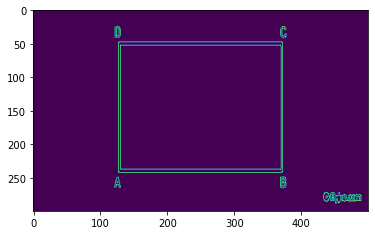

In [23]:
canny = cv2.Canny(img, 150, 150)
plt.imshow(canny)

In [24]:
edges = np.array(np.where(canny > 100)).transpose()

In [25]:
hough = HoughTransform()

In [26]:
voting_table = hough.voting(edges)

In [27]:
indices = hough.get_k_max_indices(voting_table, 2, 60)

In [28]:
lines = np.array(list(map(lambda x: hough.get_param(x[0], x[1]), indices)))

In [29]:
x1 = np.zeros(lines.shape[0])
x2 = np.ones(lines.shape[0]) * WIDTH
y1 = lines[:,1] / np.sin(lines[:, 0])
y2 = (lines[:,1] - x2 * np.cos(lines[:, 0])) / np.sin(lines[:, 0])

In [30]:
points = np.int32(np.vstack((x1,y1, x2, y2)).transpose())

In [31]:
points.shape

(2, 4)

In [32]:
ret = draw_line(img, points)

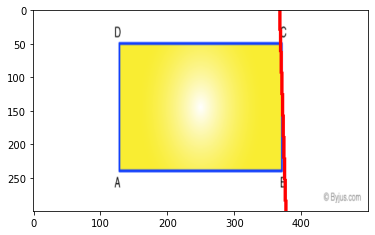

In [33]:
plt.imshow(ret)

# Houghe Circle

In [1]:
!wget -O image.png https://techmaster.vn/media/fileman/Uploads/ImageBlog/OpenCV-la-gi-04072016-1.jpg

--2021-01-03 09:15:24--  https://techmaster.vn/media/fileman/Uploads/ImageBlog/OpenCV-la-gi-04072016-1.jpg
Resolving techmaster.vn (techmaster.vn)... 45.118.144.97
Connecting to techmaster.vn (techmaster.vn)|45.118.144.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘image.png’

image.png               [ <=>                ]  13.48K  86.7KB/s    in 0.2s    

Last-modified header invalid -- time-stamp ignored.
2021-01-03 09:15:25 (86.7 KB/s) - ‘image.png’ saved [13803]



In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import progressbar
import threading

In [3]:
class HoughCircle:
  def __init__(self, clean_space=4):
    self.clean_space = clean_space
  
  def rad2deg(self, rad):
    return rad * 180 / np.pi
  def deg2rad(self, deg):
    return deg / 180 * np.pi

  def voting(self, edges, width, height, radius_range):
    r_min, r_max = radius_range
    voting_table = np.zeros((height, width, r_max - r_min + 1), dtype=np.int32)

    widgets = ['Voting: ', progressbar.SimpleProgress(), progressbar.Bar(), progressbar.ETA()]
    pbar = progressbar.ProgressBar(widgets=widgets, max_value=len(edges)).start()
    threads = []
    for i, (y,x) in enumerate(edges):
      yc,xc = np.indices((height, width))
      yc = yc.ravel()
      xc = xc.ravel()
      r = np.sqrt((xc-x)**2 + (yc-y)**2).astype(np.int32)
      pos = np.where(np.logical_and(r >= r_min, r < r_max))[0]
      voting_table[yc[pos],xc[pos],r[pos]-r_min] += 1
      pbar.update(i)
    return voting_table

  def voting_thread(self, edges, width, height, radius_range):
    r_min, r_max = radius_range
    voting_table = np.zeros((height, width, r_max - r_min + 1), dtype=np.int32)

    widgets = ['Voting: ', progressbar.SimpleProgress(), progressbar.Bar(), progressbar.ETA()]
    pbar = progressbar.ProgressBar(widgets=widgets, max_value=len(edges)).start()
    threads = []
    for i, edge in enumerate(edges):
      thread = threading.Thread(target=self.vote, args=(edge, voting_table, r_min, r_max, (height,width)))
      thread.start()
      threads.append(thread)
      pbar.update(i)
    pbar.finish()
    list(map(lambda thread: thread.join(), threads))
    return voting_table

  def vote(self, edge, voting_table, r_min, r_max, shape):
    y,x = edge
    yc,xc = np.indices(shape)
    yc = yc.ravel()
    xc = xc.ravel()
    r = np.sqrt((xc-x)**2 + (yc-y)**2).astype(np.int32)
    pos = np.where(np.logical_and(r >= r_min, r < r_max))[0]
    voting_table[yc[pos],xc[pos],r[pos]-r_min] += 1
  
  def get_k_max(self, k):
    voting_table = self.voting_table.copy()
    ret = []
    while k > 0 and len(np.where(voting_table > 0)) > 0:
      pos = np.int32(np.unravel_index(np.argmax(voting_table), voting_table.shape))
      self.cleanNeighbor(voting_table, pos)
      ret.append(pos)
      k -= 1
    return np.array(ret)

  def cleanNeighbor(self, voting_table, pos):
    y, x, r = pos
    Y, X, R = self.voting_table.shape

    min_x = np.clip(x-self.clean_space, 0, X)
    max_x = np.clip(x+self.clean_space, 0, X)

    min_y = np.clip(y-self.clean_space, 0, Y)
    max_y = np.clip(y+self.clean_space, 0, Y)

    min_r = np.clip(r-self.clean_space, 0, R)
    max_r = np.clip(r+self.clean_space, 0, R)

    voting_table[min_y:max_y, min_x:max_x, min_r:max_r] = 0


  def fit(self, edges, shape, radius_range, threading=True, num_circle=1):
    if threading:
      self.voting_table = self.voting_thread(edges, shape[1], shape[0], radius_range)
    else:
      self.voting_table = self.voting(edges, shape[1], shape[0], radius_range)
    pos = self.get_k_max(num_circle)
    pos[:,2] = pos[:,2] + radius_range[0] 
    return pos

In [4]:
img = cv2.imread('image.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hough = HoughCircle()

In [5]:
gauss = cv2.GaussianBlur(gray, (5,5), 1)
canny = cv2.Canny(gauss, 75, 150)

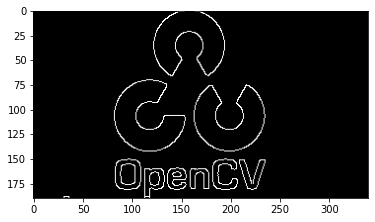

In [6]:
plt.imshow(canny, cmap='gray')

In [7]:
edges = np.array(np.where(canny > 10)).transpose()

In [8]:
mask = np.zeros((img.shape[:2]))
for yc, xc, r in hough.fit(edges, img.shape[:2], (10, 60), True, 2):
  mask = cv2.circle(mask, (xc,yc), r, (255,255,255), -1)
  print('\nCenter is: \t{0}\nRadius is: \t{1}'.format((xc,yc),r))

Voting: 1909 of 1909|###########################################|Time:  0:00:02



Center is: 	(199, 106)
Radius is: 	35

Center is: 	(118, 106)
Radius is: 	36


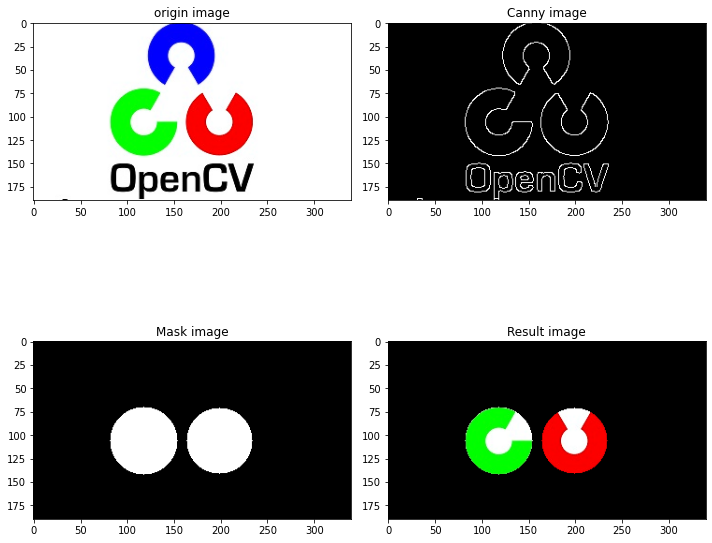

In [9]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(10,10)
ax[0,0].imshow(img)
ax[0,0].set_title('Origin image')
ax[0,1].imshow(canny, cmap='gray')
ax[0,1].set_title('Canny image')

ax[1,0].imshow(mask, cmap='gray')
ax[1,0].set_title('Mask image')


ax[1,1].imshow(cv2.bitwise_and(img, img, mask=mask.astype(np.uint8)))
ax[1,1].set_title('Result image')

fig.tight_layout()
fig.show()